# FEM 2D multiscale example

This script shows a two dimensional example where the standard FEM evaluates an approximation to the equation

$$\ddot{u}_\varepsilon - \nabla \cdot (A_\varepsilon \nabla \dot{u}_\varepsilon + B_\varepsilon \nabla u_\varepsilon) = 1, \ \text{in } \Omega,$$

with homogeneous Dirchlet boundary condition. First initialize the fine settings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from visualize import drawCoefficient, d3sol, d3solextra
from gridlod import util, fem
from gridlod.world import World
import femsolverWave, buildcoef2d

'''
Settings
'''

bg = 0.01
val = 1

#fine World
fine = 1024
NWorldFine = np.array([fine, fine])
NpFine = np.prod(NWorldFine + 1)
NList = [fine, 2, 4, 8, 16, 32, 64, 128]
NFine = np.array([fine])
xt = util.tCoordinates(NFine).flatten()
boundaryConditions = np.array([[0, 0],
                               [0, 0]])

Create the 2D coefficients using buildcoef2d.

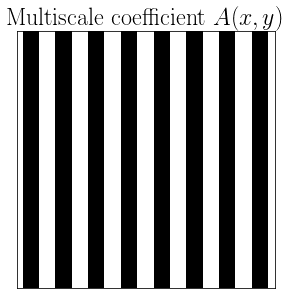

In [2]:
'''
Create coefficients
'''

CoefClass = buildcoef2d.Coefficient2d(NWorldFine,
                                            bg                  = bg,
                                            val                 = val,
                                            length              = 1,
                                            thick               = 65,
                                            space               = 65,
                                            probfactor          = 1,
                                            right               = 1,
                                            down                = 0,
                                            diagr1              = 0,
                                            diagr2              = 0,
                                            diagl1              = 0,
                                            diagl2              = 0,
                                            LenSwitch           = None,
                                            thickSwitch         = None,
                                            equidistant         = True,
                                            ChannelHorizontal   = None,
                                            ChannelVertical     = True,
                                            BoundarySpace       = None,
                                            Boxes2n             = None,
                                            Channels2n          = None,
                                            TestExample         = True)


A = CoefClass.BuildCoefficient()
ABase = A.flatten()
plt.figure("OriginalCoefficient")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
drawCoefficient(NWorldFine, ABase)
plt.title(r'Multiscale coefficient $A(x,y)$', fontsize=24)
plt.show()

B = np.ones((len(xt),len(xt)))
BBase = B.flatten()

Compute and plot solutions.

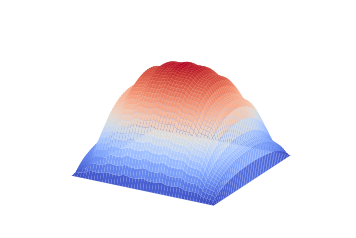

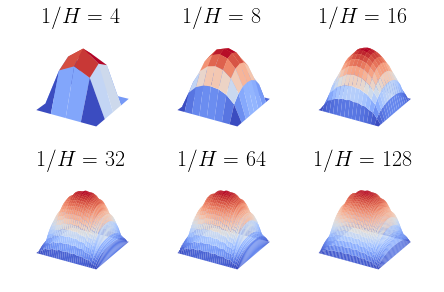

In [3]:
tau = 0.1
k = 0
newErrorFine = []
x = []
y = []
for N in NList:

    # coarse settings
    NWorldCoarse = np.array([N,N])
    NpCoarse = np.prod(NWorldCoarse+1)
    NCoarseElement = NWorldFine / NWorldCoarse
    world = World(NWorldCoarse, NCoarseElement, boundaryConditions)
    AFine = fem.assemblePatchMatrix(NWorldFine, world.ALocFine, ABase)


    # grid nodes
    xpCoarse = util.pCoordinates(NWorldCoarse).flatten()
    NpCoarse = np.prod(NWorldCoarse + 1)
    f = np.ones(NpFine)
    Uo = np.zeros(NpCoarse)
    Vo = np.ones(NpCoarse)
    U = [Uo]

    uSolv = []
    for i in xrange(2):
        uCoarseFull = femsolverWave.solveCoarse_fem(world, ABase, BBase, f, U, tau, boundaryConditions, i)
        uSolv.append(uCoarseFull)
        U.append(uCoarseFull)

    basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
    uLodCoarse = basis*uCoarseFull

    if N == fine:
        uSol = uCoarseFull
    else:
        newErrorFine.append(np.sqrt(np.dot(uSol - uLodCoarse, (uSol - uLodCoarse))))
        x.append(N)
        y.append(1./N + NList[-k])
    k = k + 1
    ymin = np.min(uSol)
    ymax = np.max(uSol)

    '''
    Plot solutions
    '''

    if np.size(x)==2:
        fig = plt.figure('FEM-Solution')
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        fig.subplots_adjust(left=0.01,bottom=0.04,right=0.99,top=0.95,wspace=0,hspace=0.2)
        ax = fig.add_subplot(231, projection='3d')
        ax.set_title(r'$1/H=$ ' + str(N),fontsize=22)
    elif np.size(x)==3:
        ax = fig.add_subplot(232, projection='3d')
        ax.set_title(r'$1/H=$ ' + str(N),fontsize=22)
    elif np.size(x)==4:
        ax = fig.add_subplot(233, projection='3d')
        ax.set_title(r'$1/H=$ ' + str(N),fontsize=22)
    elif np.size(x)==5:
        ax = fig.add_subplot(234, projection='3d')
        ax.set_title(r'$1/H=$ ' + str(N),fontsize=22)
    elif np.size(x)==6:
        ax = fig.add_subplot(235, projection='3d')
        ax.set_title(r'$1/H=$ ' + str(N),fontsize=22)
    elif np.size(x)==7:
        ax = fig.add_subplot(236, projection='3d')
        ax.set_title(r'$1/H=$ ' + str(N),fontsize=22)

    if N == fine:
        d3sol(NWorldCoarse, uCoarseFull)
    elif N == 2:
        init = 0
    else:
        d3solextra(NWorldCoarse, uCoarseFull, fig, ax, ymin, ymax)

plt.show()

Plot the $L^2$-error.

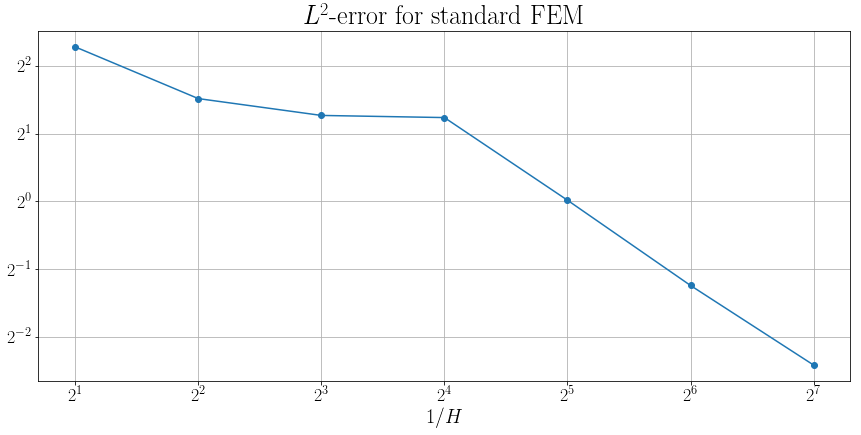

In [4]:
# plot errors
plt.figure("Error", figsize=(12,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.subplots_adjust(left=0.05, bottom=0.11, right=0.99, top=0.92, wspace=0.1, hspace=0.2)
plt.tick_params(labelsize=18)
plt.loglog(x,newErrorFine,'o-', basex=2, basey=2)
plt.xlabel(r'$1/H$', fontsize=20)
plt.title(r'$L^2$-error for standard FEM', fontsize=26)
plt.grid(True,which="both")
plt.show()